In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [2]:
%%time
np.random.seed(174)
edges = pd.read_csv('edges.csv')
ids = pd.read_csv('ids.csv')
vertices = pd.read_csv('vertices.csv')
vertices['main_okved'] = vertices['main_okved'].astype(str)
vertices = vertices.set_index('id')

CPU times: user 3.34 s, sys: 565 ms, total: 3.91 s
Wall time: 3.77 s


## Exploratory data analysis

In [3]:
vert_stats = pd.merge(edges.id_1.value_counts(), edges.id_2.value_counts(), left_index=True, right_index=True, how='outer').fillna(0)
vert_stats['power'] = vert_stats['id_1'] + vert_stats['id_2']
vertices = pd.merge(vertices, vert_stats['power'], left_index=True, right_index=True, how='outer').fillna(0)

In [4]:
# accomplish this
edges.groupby('id_1').agg({'value':['mean', 'median'], 'n_transactions': ['mean', 'median']})

value                n_transactions            
                  mean         median           mean      median
id_1                                                            
1        373907.924027  373907.924027       1.000000    1.000000
2        464659.927278  464659.927278      93.874744   93.874744
3        478866.322798  478866.322798     207.791701  207.791701
4        340297.565750  323833.016533     151.152045    1.000000
5        394605.971982  410382.392687     133.873719   93.874744
...                ...            ...            ...         ...
1532726  304254.776513  304254.776513      80.997950   80.997950
1533068  344378.140883  344378.140883       1.000000    1.000000
1533321  376692.491055  376692.491055       1.000000    1.000000
1534041  448364.213929  448364.213929     277.747437  277.747437
1534210     191.000000     191.000000       1.000000    1.000000

[1017864 rows x 4 columns]

### Nodes statistics
Boxplot for amount of connections per copmany is something amazing :)

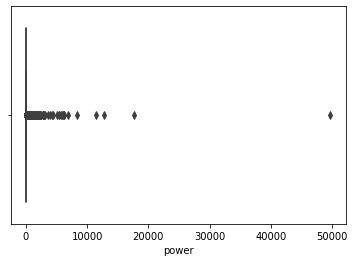

In [5]:
sns.boxplot(vertices.power);

99% of companies in this dataset have less than 76 connection with other companies.

In [6]:
vertices[['power']].describe(percentiles=[0.8, 0.85, 0.9, 0.95, 0.99, 0.995, 0.999], include='all').T.round(1)

,count,mean,std,min,50%,80%,85%,90%,95%,99%,99.5%,99.9%,max
power,1534749.0,6.1,54.3,0.0,2.0,5.0,7.0,10.0,19.0,76.0,124.0,320.0,49733.0


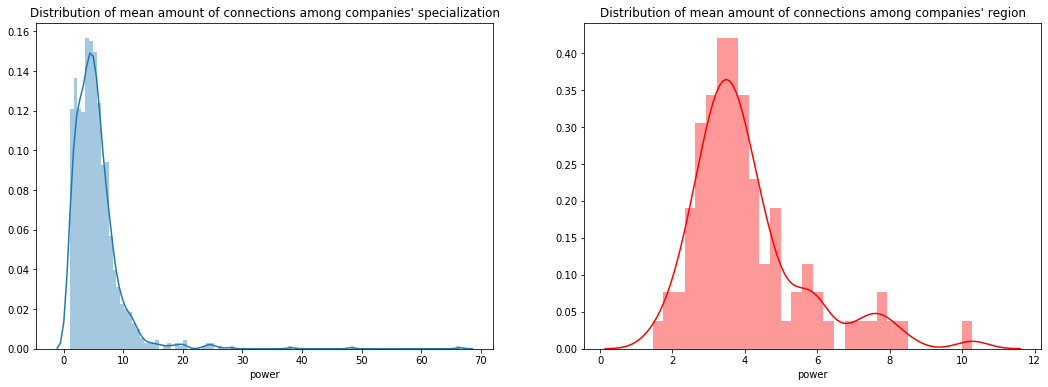

In [7]:
plt.figure(figsize=(18, 6))
plt.subplot(121);
plt.title('Distribution of mean amount of connections among companies\' specialization');
sns.distplot(vertices.groupby('main_okved').power.mean(), bins=100);
plt.subplot(122);
plt.title('Distribution of mean amount of connections among companies\' region');
sns.distplot(vertices.groupby('region_code').power.mean(), bins=30, color='red');

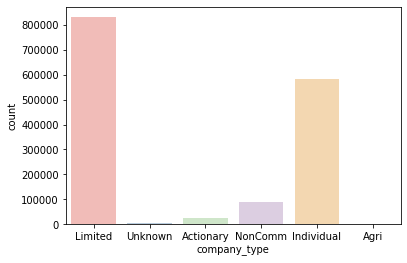

In [8]:
sns.countplot(x='company_type', data=vertices, palette="Pastel1");

In [11]:
import networkx as nx

In [12]:
edges_for_graph =  [(x[0], x[1]) for x in edges[['id_1', 'id_2']].itertuples(index=False)]
G = nx.Graph()
G.add_nodes_from(vertices.index.values)
G.add_edges_from(edges_for_graph)

Let's check if there are some isolated vertices. 

In [13]:
%%time
nx.number_of_isolates(G)

CPU times: user 528 ms, sys: 6.6 ms, total: 535 ms
Wall time: 558 ms


20036

Wow, it's kinda 1.3% of isolated vertices in our graph. Definitely should take a look at it later :) 

## Link prediction approach

We used [this implementation](https://github.com/louisabraham/fastnode2vec) of [Node2Vec](https://arxiv.org/pdf/1607.00653.pdf)

In [ ]:
from fastnode2vec import Graph, Node2Vec
import networkx as nx

In [ ]:
%%time
edges_for_graph = [(x[0], x[1]) for x in edges[['id_1', 'id_2']].itertuples(index=False)]
graph = Graph(edges_for_graph, directed=False)

In [ ]:
%%time
n2v = Node2Vec(graph,
               dim=256,
               walk_length=80,
               context=10,
               p=1.0,
               q=1.0,
               workers=8) #may take up to 5 min to initialize

In [ ]:
n2v.train(epochs=25)
n2v.save('dim256_wl80_ctx10_pq11_e10.model')

You can just load already trained model, instead of waiting up to 10h.

In [ ]:
from gensim.models import Word2Vec
from sklearn.linear_model import LogisticRegression

In [ ]:
%%time
#link to pretrained model https://drive.google.com/drive/folders/1CWVD8a72yn4ZyA28PXfMUKyJw6X4eFiF?usp=sharing
n2v = Word2Vec.load('dim256_wl80_ctx10_pq11_e10.model')

In [ ]:
lr = LogisticRegression(#class_weight='balanced',
                        random_state=183269,
                        solver='liblinear',
                        max_iter=500)

In [ ]:
def node_embs_bslike(node_list):
    embs = []
    for i in node_list:
        embs.append(n2v.wv[str(i)])
    return np.array(embs).astype(np.float64)

In [1]:
def edge_embs_bslike(node, node_list):
    embs = []
    emb1 = n2v.wv[str(node)]
    for id_2 in node_list:
        emb2 = n2v.wv[str(id_2)]
        edge_emb = np.multiply(emb1, emb2)
        embs.append(edge_emb)
    embs = np.array(embs).astype(np.float64)
    return embs

In [ ]:
result = pd.DataFrame(columns=['id_1', 'id_2', 'preds'])
g_idx = vertices.id.isin(np.array(edges_for_graph).flatten()).values

In [ ]:
for i in tqdm(ids.id):
    df1 = edges[edges['id_1'] == i].reset_index()
    df2 = edges[edges['id_2'] == i].reset_index()
    df = df1[['id_2', 'id_1']].rename(columns={'id_1':'id_2', 'id_2':'id_1'}).append(df2[['id_1', 'id_2']])
    df['target'] = 1
    df = vertices.set_index('id').join(df.set_index('id_1')['target']).fillna(0)
    df = df[g_idx]

    pos_idx = df[df['target']==1].index.values
    neg_idx = np.random.choice(df[df['target']==0].index.values, size=len(pos_idx), replace=False)

    train_idx = np.append(pos_idx, neg_idx)
    target = df.loc[train_idx, 'target']

    test_idx = df[df['target']==0].index.values

    
    lr.fit(node_embs_bslike(train_idx), target.to_numpy())
    #or you can use edge embeddings edge_embs_bslike(i, train_idx) like in paper 
    
    df.loc[test_idx, 'preds'] = lr.predict_proba(node_embs_bslike(test_idx))[:, 1]

    df['id_2'] = i
    res = df.loc[test_idx, ['id_2', 'preds']].sort_values(by='preds', ascending=False).iloc[:2000].reset_index()[['id', 'id_2', 'preds']]
    res.columns = ['id_1', 'id_2', 'preds']
    result = result.append(res, ignore_index=True, sort=False)
result.to_csv('node2vec_result.csv', index=False)

Lets also create light version of embedding matrix for models stacking

In [ ]:
n2v_s = Node2Vec(graph,
               dim=128,
               walk_length=80,
               context=10,
               p=1.0,
               q=1.0,
               workers=8)
n2v_s.train(epochs=10)

In [ ]:
embs = {}
for i in set(np.array(edges_for_graph).flatten()):
    embs[str(i)] = n2v_s.wv[str(i)]
with open('embs.pickle', 'wb') as f:
     pickle.dump(embs, f)